# Exo 1: Imaging Inverse Problems with Explicit Regularization

<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2324/tp5_exo1_inverse_problem_with_explicit_regularization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

In this practical session, you have to complete the code regions marked ``### ... ###``.

In [ ]:
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
print(torch.__version__)

pi = torch.pi

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    mse = np.sqrt(np.mean((np.array(uref)-np.array(ut))**2))
    return 20*np.log10(M/mse)

def optim(f,niter=1000,lr=0.1):
    u = torch.randn(M,N, requires_grad=True)
    optimu = torch.optim.SGD([u], lr=lr)
    losslist = []
    for it in range(niter):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
    return u.detach(),losslist

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,z=2,order=0,titre='',displayfilename = False):
    imin= np.array(im).copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

!wget https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
!unzip tpdeblur.zip

2.2.1+cu121
--2024-03-25 15:51:59--  https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774047 (756K) [application/zip]
Saving to: ‘tpdeblur.zip’

tpdeblur.zip        100%[===================>] 755.91K  2.03MB/s    in 0.4s    

2024-03-25 15:52:00 (2.03 MB/s) - ‘tpdeblur.zip’ saved [774047/774047]

Archive:  tpdeblur.zip
   creating: im/
  inflating: im/simpson512crop.png   
  inflating: im/simpson512.png       
  inflating: im/room.png             
  inflating: im/tshirt.png           
   creating: kernels/
  inflating: kernels/kernel_0.png    
  inflating: kernels/kernel_1.png    
  inflating: kernels/kernel_10.png   
  inflating: kernels/kernel_11.png   
  inflating: kernels/kernel_2.png    
  inflating: ker

# A) Deblurring with Tychonov and $\mathsf{TV}_\varepsilon$ regularizations

<br/>In this practical session, you have to fill the code at places marked ``### ... ###``

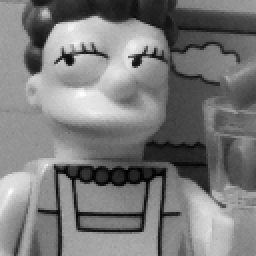

In [ ]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512crop.png')))
M,N = u0.shape

viewimage(u0)

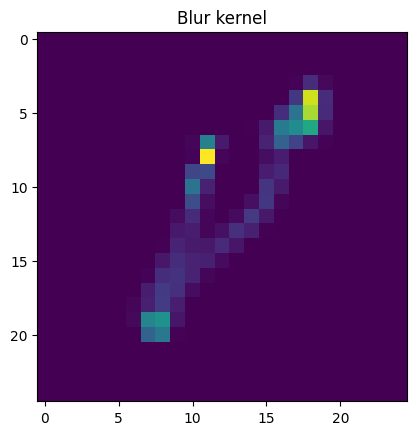

In [ ]:
# Load a blur kernel
kt = torch.tensor(np.loadtxt('kernels/kernel8.txt'))
# kt = np.loadtxt('kernels/levin7.txt')
(m,n) = kt.shape

plt.imshow(kt)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((M,N))
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1))
fk = fft2(k)

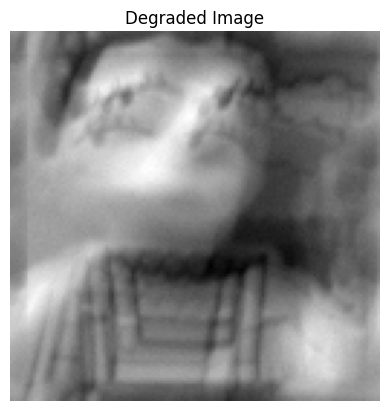

In [ ]:
# Compute the degraded image v = k*u0 + w  (convolution with periodic boundary conditions)
sigma = 0.02
w = torch.randn(u0.size())
v = ifft2(fft2(k)*fft2(u0) + w)

plt.figure(dpi=100)
plt.imshow(v.real,cmap='gray')
plt.title('Degraded Image')
plt.axis('off')
plt.show()

## Deblurring with Tychonov regularization

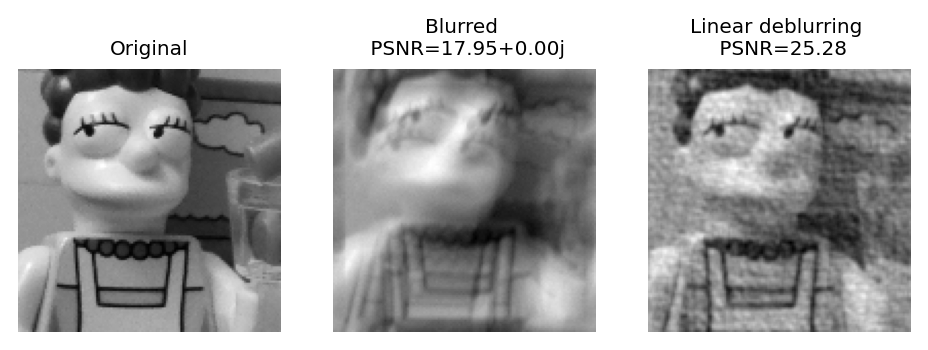

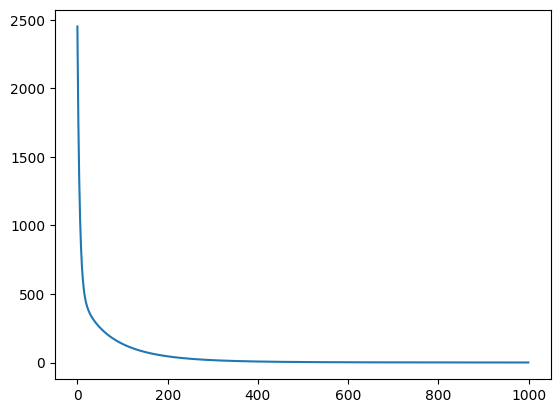

In [ ]:
# Write the functional with data-fidelity and regularization with weight lam>0.
def Ft(u, lam=1):
    u1 = torch.roll(u,-1,0) - u
    u2 = torch.roll(u,-1,1) - u
    return 1/2*torch.norm(ifft2(fft2(k)*fft2(u)) - v)**2 + lam/2*(torch.norm(u1)**2 + torch.norm(u2)**2)


lam = 0.01
tau = 2/(1 + 16*lam)

F = lambda u : Ft(u,lam)
u,losslist = optim(F)
utych = u

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v.real, cmap='gray')
plt.title('Blurred \n PSNR='+str2(psnr(u0,v)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u, cmap='gray')
plt.title('Linear deblurring \n PSNR='+str2(psnr(u0,u)),fontsize=8)
plt.axis('off')
plt.show()

plt.figure(dpi=100)
plt.plot(losslist)
plt.show()

In [ ]:
# Compare with explicit computation of Tychonov deblurring

xi = torch.arange(M)
ind = (xi>M/2)
xi[ind] = xi[ind]-M
zeta = torch.arange(N)
ind = (zeta>N/2)
zeta[ind] = zeta[ind]-N
Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')

L = torch.tensor([[4*(np.sin(np.pi*i/M)**2 + np.sin(np.pi*j/N)**2) for i in range(M)] for j in range(N)])

us = fft2(v)/(1 + 2*L*lam)
us = ifft2(us).real

print('Final error = ',torch.sqrt(torch.sum((u-us)**2)))


Final error =  tensor(15.5645, dtype=torch.float64)


## Deblurring with smoothed total variation

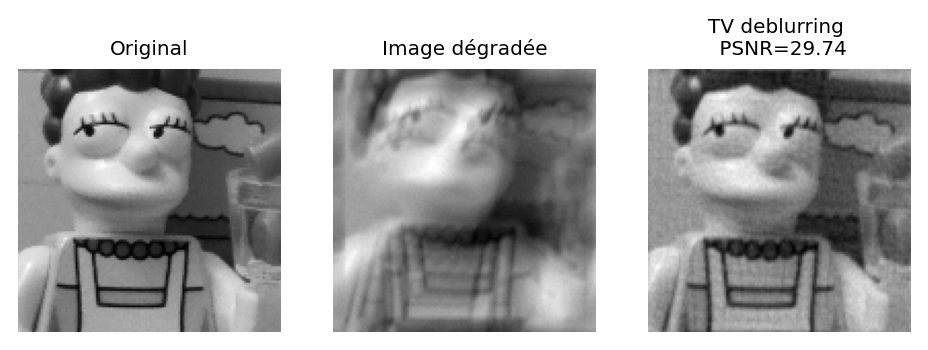

In [ ]:
# Write the functional with data-fidelity and regularization with weight lam>0.
def Gt(u, lam=1, ep=0.01):
    u1 = torch.roll(u,-1,0) - u
    u2 = torch.roll(u,-1,1) - u
    return 1/2*torch.norm(ifft2(fft2(k)*fft2(u)) - v)**2 + lam/2*torch.sqrt(ep + torch.norm(u1)**2 + torch.norm(u2)**2)


lam = 0.1
ep = 0.01

tau = 2/(1 + 8*lam/ep)

G = lambda u : Gt(u,lam)
u_tv,losslist = optim(G, lr = 1)

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v.real, cmap='gray')
plt.title('Image dégradée',fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u_tv, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,u_tv)),fontsize=8)
plt.axis('off')
plt.show()

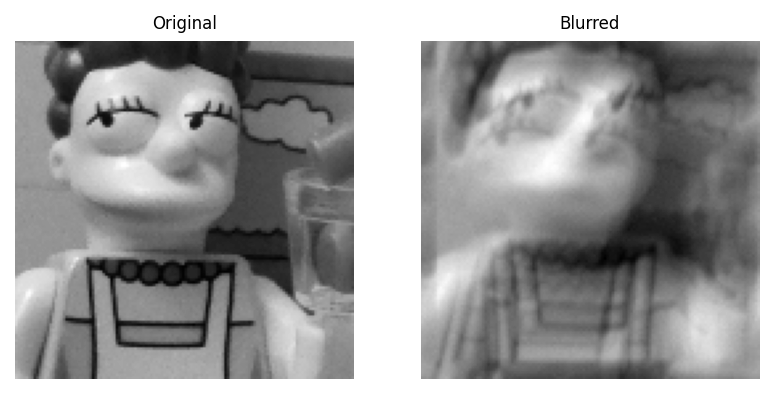

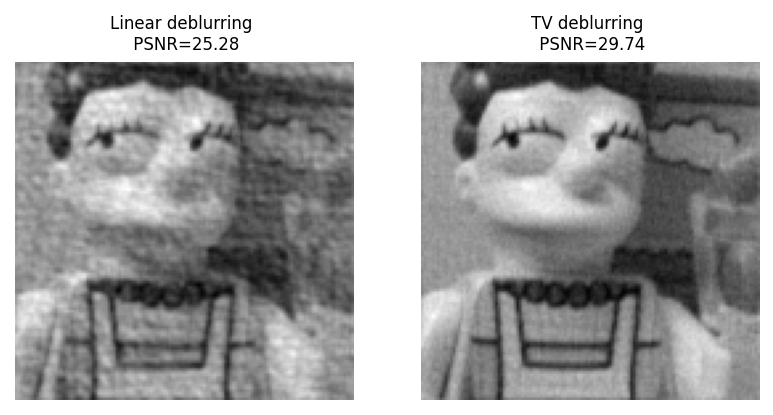

In [ ]:
# Compare deblurring results with Tychonov regularization and TV regularization

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(v.real, cmap='gray')
plt.title('Blurred',fontsize=8)
plt.axis('off')
plt.show()

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(utych, cmap='gray')
plt.title('Linear deblurring \n PSNR='+str2(psnr(u0,utych)),fontsize=8)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(u_tv.real, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,u_tv.real)),fontsize=8)
plt.axis('off')
plt.show()

## Adjusting the regularization parameter

In [ ]:
# Find the value of the regularization parameter lambda that optimizes the PSNR
# Do it first for Tychonov regularization, and then for smoothed TV.
# Compare the final restoration results obtained with these oracle values of lambda.

### ... ###

<br/><br/><br/><br/><br/>

# B) Inpainting with $\mathsf{TV}_{\varepsilon}$ regularization (at home)

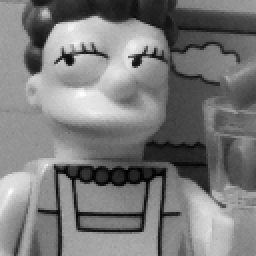

In [ ]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512crop.png')))
M,N = u0.shape

viewimage(u0)

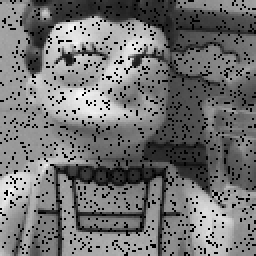

In [ ]:
# Generate a random mask with proportion p of masked pixels
p = .9
mask = (torch.rand(M,N)<p)*1.
# other choice:
#mask = torch.ones(M,N)
#mask[:,60:65] = 0

v = u0*mask

viewimage(v)

## Relaxed Inpainting

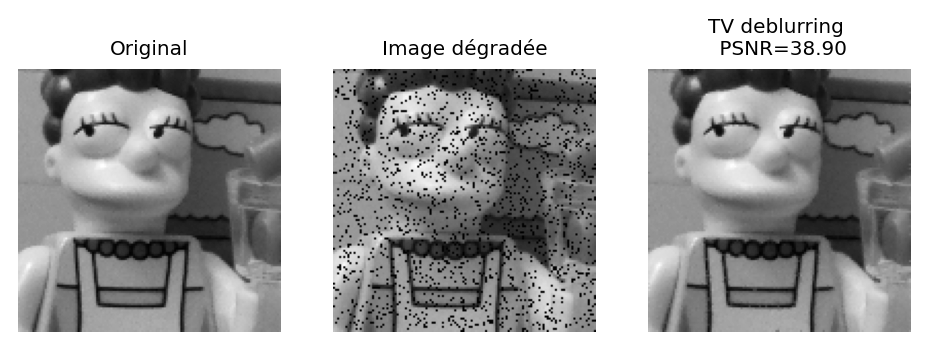

In [ ]:
# Perform relaxed TV inpainting by minimizing 1/2 |u-v|^2 + tv_ep(u)

# Write the functional with data-fidelity and regularization with weight lam>0.
def At(u, lam=1, ep=0.01):
    u1 = torch.roll(u,-1,0) - u #x-axis
    u2 = torch.roll(u,-1,1) - u #y-axis
    return 1/2*torch.norm(u*mask - v)**2 + lam/2*torch.sqrt(ep + torch.norm(u1)**2 + torch.norm(u2)**2)


lam = 0.1
ep = 0.01

tau = 2/(1 + 8*lam/ep)

A = lambda u : At(u,lam)
u_tv_mask,losslist = optim(A, lr = 1)

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v.real, cmap='gray')
plt.title('Image dégradée',fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u_tv_mask, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,u_tv_mask)),fontsize=8)
plt.axis('off')
plt.show()

## Constrained Inpainting (with Projected Gradient Descent)

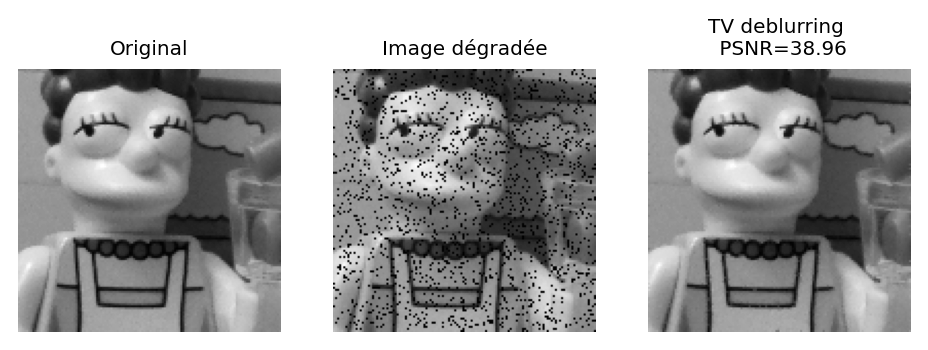

In [ ]:
# Perform constrained TV inpainting by minimizing tv_ep(u) with constraint u = v outside the mask

def optim_c(f,niter=1000,lr=0.1):
    u = torch.randn(M,N, requires_grad=True)
    optimu = torch.optim.SGD([u], lr=lr)
    losslist = []
    for it in range(niter):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
        with torch.no_grad():
          u[mask>0] = v[mask>0]
        #u.data = torch.tensor([[v[j,i] if mask[j,i] == 1 else u[j,i] for i in range(128)] for j in range(128)]) #projection step
    return u.detach(),losslist

# Write the functional with data-fidelity and regularization with weight lam>0.
def Zt(u, lam=1, ep=0.01):
    u1 = torch.roll(u,-1,0) - u
    u2 = torch.roll(u,-1,1) - u
    return lam/2*torch.sqrt(ep**2 + torch.norm(u1)**2 + torch.norm(u2)**2)


lam = 0.1
ep = 0.01

tau = 2/(1 + 8*lam/ep)

Z = lambda u : Zt(u,lam)
u_tv_mask_c,losslist = optim_c(Z, lr = 1)

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v.real, cmap='gray')
plt.title('Image dégradée',fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u_tv_mask_c.real, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,u_tv_mask_c)),fontsize=8)
plt.axis('off')
plt.show()

<br/><br/><br/><br/><br/>

## C) Super-resolution (at home)
I don't understand what i am supposed to do

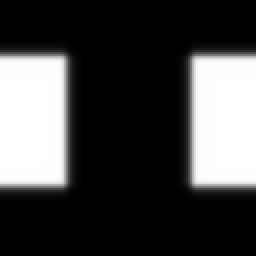

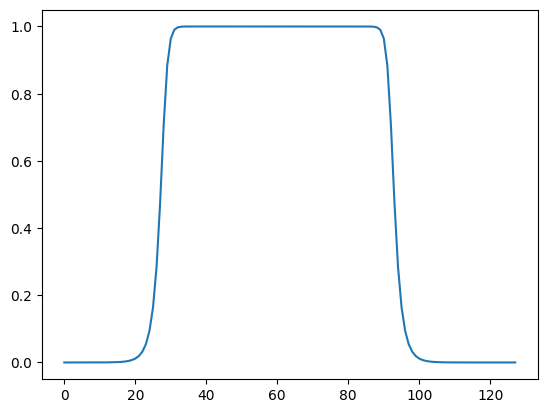

In [ ]:
# Adjust the framework to address super-resolution with smoothed TV
# For anti-aliasing, you may use the Butterworth filter of order n and cut-off frequency fc
#   given below
f = 0
fc = 0.5  # cutoff frequency
n=20      # order of the filter

bf = 1/np.sqrt(1+(f/fc)**(2*n))

xi = torch.arange(M)
ind = (xi>M/2)
xi[ind] = xi[ind]-M
zeta = torch.arange(N)
ind = (zeta>N/2)
zeta[ind] = zeta[ind] - N
Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')

bf1 = 1/torch.sqrt(1+(Xi/(M*fc/2))**(2*n))
bf2 = 1/torch.sqrt(1+(Zeta/(N*fc/2))**(2*n))
bf = bf1*bf2 #Le filtre est déjà dans l'espace des fréquences

s = 2
v = ifft2(bf*fft2(u0))
v = v[::s,::s] + 0.1*torch.randn((64,64))

viewimage(torch.roll(bf, 60,0))

plt.figure(dpi=100)
plt.plot(torch.roll(bf[0,:], 60, 0))
plt.show()

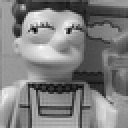

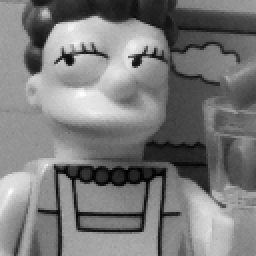

In [ ]:
viewimage(v.real)
viewimage(u0.real)

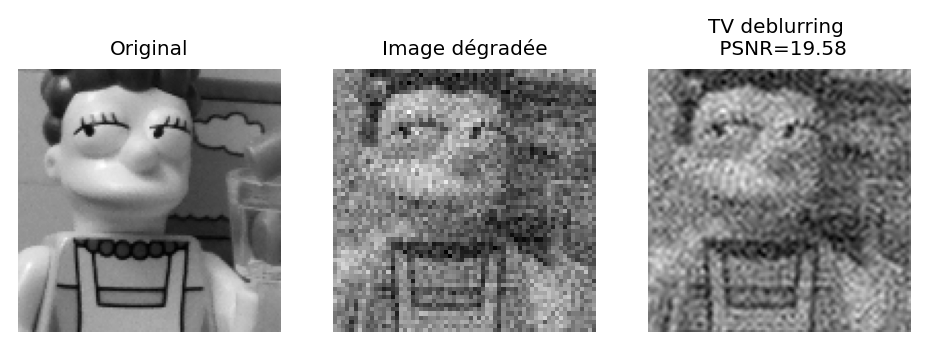

In [ ]:
def optim(f,niter=1000,lr=0.1):
    u = torch.randn(M,N, requires_grad=True)
    optimu = torch.optim.SGD([u], lr=lr)
    losslist = []
    for it in range(niter):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
    return u.detach(),losslist

# Write the functional with data-fidelity and regularization with weight lam>0.
def St(u, lam=1, ep=0.01, s = 2):
    u1 = torch.roll(u,-1,0) - u
    u2 = torch.roll(u,-1,1) - u
    bf_u = ifft2(bf*fft2(u))
    bf_u = bf_u[::s,::s]
    return 1/2*torch.norm(bf_u - v)**2 + lam/2*torch.sqrt(ep**2 + torch.norm(u1)**2 + torch.norm(u2)**2)

lam = 0.1
ep = 1

tau = 2/(1 + 8*lam/ep)

S = lambda u : St(u,lam)
u_sr,losslist = optim(S, lr = 5)

plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(v.real, cmap='gray')
plt.title('Image dégradée',fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(u_sr.real, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,u_sr.real)),fontsize=8)
plt.axis('off')
plt.show()

In [ ]:
# Adjust your code to that it can handle color images
#I think everything is the same, we just have to make an objective for each colour and optimize independantly

<br/><br/><br/><br/><br/>

## D) Deblurring with non-periodic boundary conditions (at home)
Don't understand what I am supposed to do. Use zero-padding ?

In [ ]:
# Adjust the deblurring code so that the blur operator is implemented without boundary conditions.
# -> After the convolution operator by the (2s+1)x(2s+1) kernel, you cut a s border on each side.
#here 2s + 1 = 25 so s = 12

